In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


Kaggle credentials set.
Kaggle credentials successfully validated.


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

abdessamiguebli_qtdb_ludb_path = kagglehub.dataset_download('abdessamiguebli/qtdb-ludb')

print('Data source import complete.')


100%|██████████| 132M/132M [00:04<00:00, 27.8MB/s]

Extracting files...


Data source import complete.


In [ ]:
!pip install wfdb
!pip install keras-tuner --quiet
!pip install resnet1d
!pip install tqdm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 80.1 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.6 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement resnet1d (from versions: none)
ERROR: No matching distribution found for resnet1d


# preprocess

In [ ]:
import wfdb
from scipy.signal import butter, filtfilt
import numpy as np
from scipy.signal import resample
from re import S
import os

In [ ]:
def bandpass_filter(signal, lowcut=0.5, highcut=10, fs=250, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)
def smooth_signal(data, window_size=5):
    # Smooth the signal using a moving average filter
    window = np.ones(window_size) / window_size
    smoothed = np.convolve(data, window, mode='same')
    return smoothed
def normalize_signal(data):
    """
    Normalize the signal using z-score normalization.
    """
    return (data - np.mean(data)) / np.std(data)

In [ ]:

from scipy.signal import resample

def resample_signal(signal, original_fs, target_fs):
    num_samples = int(len(signal) * target_fs / original_fs)
    resampled_signal = resample(signal, num_samples)
    return resampled_signal
def adjust_annotations(samples, original_fs, target_fs):
    """
    Rescales annotation sample indices from original_fs to target_fs.
    Works with scalars or lists/arrays.
    """
    scale = target_fs / original_fs
    if isinstance(samples, (list, np.ndarray)):
        return (np.array(samples) * scale).astype(int)
    else:
        return int(samples * scale)



In [ ]:


def extract_wave_regions(samples, symbols, fs, extra_ms={'p':0,'N':20,'t':0}):
    wave_regions = {'p': [], 'N': [], 't': []}
    start = None
    qrs_symbols = ['N', 'L', 'R', 'V', 'A']
    current_symbol = None
    a = fs/ 1000
    for i in range(len(symbols)):

        if symbols[i] == '(':
            start = samples[i]
            current_symbol = None
        elif symbols[i] in wave_regions:

            current_symbol = symbols[i]
        elif symbols[i] in qrs_symbols:
            current_symbol = 'N'
        elif symbols[i] == ')' and current_symbol:
            end = samples[i]
            if start and end and current_symbol:
              #print(extra_ms['p'])
              wave_regions[current_symbol].append((int(start-extra_ms[current_symbol]*a), int(end+extra_ms[current_symbol]*a)))

            start = None
            current_symbol = None
    return wave_regions


In [ ]:
def create_multi_class_mask(length, wave_regions):

    mask = np.zeros((length, 4))  # [BG, P, QRS, T]
    label_map = {'p': 1, 'N': 2, 't': 3}
    for label, regions in wave_regions.items():
        for start, end in regions:
            start = max(0, start)
            end = min(length, end)
            mask[start:end, label_map[label]] = 1

    mask[:, 0] = (mask[:, 1:] == 0).all(axis=1).astype(float)
    return mask

In [ ]:
def segment_signal_and_mask(signal, mask, window_size, stride):
    segments, masks = [], []
    for i in range(0, len(signal) - window_size + 1, stride):
        segment = signal[i:i + window_size]
        mask_segment = mask[i:i + window_size]
        if len(segment) == window_size and len(mask_segment) == window_size:
            segments.append(segment)
            masks.append(mask_segment)
    return np.array(segments), np.array(masks)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def display_ecg_with_masks(signal, mask, fs=250):
    """
    Display the ECG signal with P, QRS, and T wave masks.

    Parameters:
        signal (numpy array): The ECG signal.
        mask (numpy array): The multi-class mask (1D or 2D).
        fs (int): Sampling frequency of the ECG signal.
    """
    time = np.arange(len(signal)) / fs  # Convert sample index to time (seconds)

    # Ensure mask is 2D (L, 4) - one-hot encoded; if not, convert it
    if mask.ndim == 1:
        num_classes = 4  # Assuming classes: [Background, P, QRS, T]
        mask = np.eye(num_classes)[mask]  # Convert to one-hot (L, 4)

    plt.figure(figsize=(15, 6))
    plt.plot(time, signal, color='black', label='ECG Signal')

    # Plot masks
    plt.fill_between(time, -1, 1, where=mask[:, 0] > 0.5, color='gray', alpha=0.3, label='background')
    plt.fill_between(time, -1, 1, where=mask[:, 1] > 0.5, color='blue', alpha=0.3, label='P wave')
    plt.fill_between(time, -1, 1, where=mask[:, 2] > 0.5, color='red', alpha=0.3, label='QRS Complex')
    plt.fill_between(time, -1, 1, where=mask[:, 3] > 0.5, color='green', alpha=0.3, label='T wave')

    plt.title("ECG Signal with Annotated Wave Regions")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()


In [ ]:
import numpy as np
import wfdb

def process_record(record_path, Type='LUDB', extra_ms={'p':0,'N':20,'t':0}, target_fs=250, window_sec=1.0):
    record = wfdb.rdrecord(record_path)
    signal = record.p_signal[:, 0]  # lead I
    fs = record.fs

    # Read annotations
    annotations = wfdb.rdann(record_path, 'pu0' if Type == 'QTDB' else 'i')
    samples = annotations.sample
    symbols = annotations.symbol

    # Define window size and stride
    window_size = 240
    stride = window_size // 4  # 60 overlap

    # Padding signal before segmentation
    remainder = (len(signal) - window_size) % stride
    padding = (stride - remainder) if remainder != 0 else 0
    if padding > 0:
        signal = np.pad(signal, (0, padding), mode='constant', constant_values=signal[-1])

    #

    # Preprocessing
    signal = normalize_signal(smooth_signal(bandpass_filter(signal, fs=fs)))
    if fs != target_fs:
        signal = resample_signal(signal, original_fs=fs, target_fs=target_fs)
        samples = adjust_annotations(samples, original_fs=fs, target_fs=target_fs)
        fs = target_fs

    # Wave region labeling
    wave_regions = extract_wave_regions(samples, symbols, fs, extra_ms=extra_ms)
    mask = create_multi_class_mask(len(signal), wave_regions)
    #

    indices = np.where(mask[:, 0] != 1)[0]  # [0] extracts the indices
    first_non_zero_row = indices[0] if len(indices) > 0 else None
    last_non_zero_row = indices[-1] if len(indices) > 0 else None
    #print(last_non_zero_row)

    padding = 5
    first_non_zero_row-=padding
    if (first_non_zero_row<0):first_non_zero_row=0
    last_non_zero_row+=padding
    if (last_non_zero_row>len(signal)-1):last_non_zero_row=len(signal)-1
    mask=mask[first_non_zero_row:last_non_zero_row]
    signal=signal[first_non_zero_row:last_non_zero_row]
    # Segment the signal and mask
    #print(signal,mask)
    segments, masks = segment_signal_and_mask(signal, mask, window_size, stride)


    # Ensure last segment ends at the last signal index
    if len(segments) * stride + window_size - stride < len(signal):
        pad_needed = len(signal) - (len(segments) * stride + window_size - stride)
        signal = np.pad(signal, (0, pad_needed), mode='constant', constant_values=signal[-1])
        mask = np.pad(mask, (0, pad_needed), mode='constant', constant_values=0)  # Assuming padding mask as background


    # Adjust final shape
    segments = np.expand_dims(segments, axis=1) # (N, 1, L)


    masks = np.argmax(masks, axis=-1)            # (N, L)
    #print("done")


    return segments, masks


In [ ]:
def get_all_records(directory, extension=".dat"):
    files = [f.replace(extension, "") for f in os.listdir(directory) if f.endswith(extension)]
    return list(set(files))  # Ensure no duplicates

# Set paths for QTDB and LUDB
path='/root/.cache/kagglehub/datasets/abdessamiguebli/qtdb-ludb/versions/2/'
qtdb_path = path + "physionet.org/files/qtdb/1.0.0/"
ludb_path = path + "physionet.org/files/ludb/1.0.1/data/"

# Get all record names dynamically
qt_records = get_all_records(qtdb_path)
lu_records = get_all_records(ludb_path)

print(f"Found {len(qt_records)} QTDB records and {len(lu_records)} LUDB records.")

Found 105 QTDB records and 200 LUDB records.


Processing QTDB Records: 100%|██████████| 105/105 [00:30<00:00,  3.46it/s]


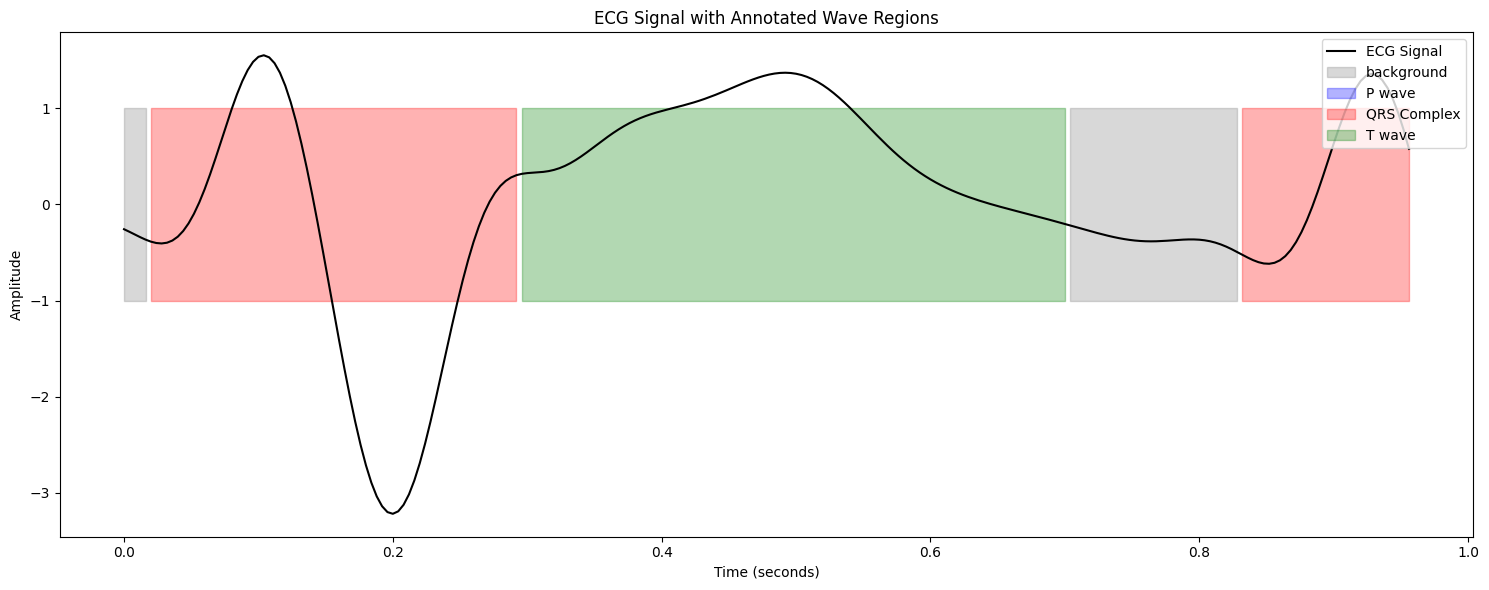

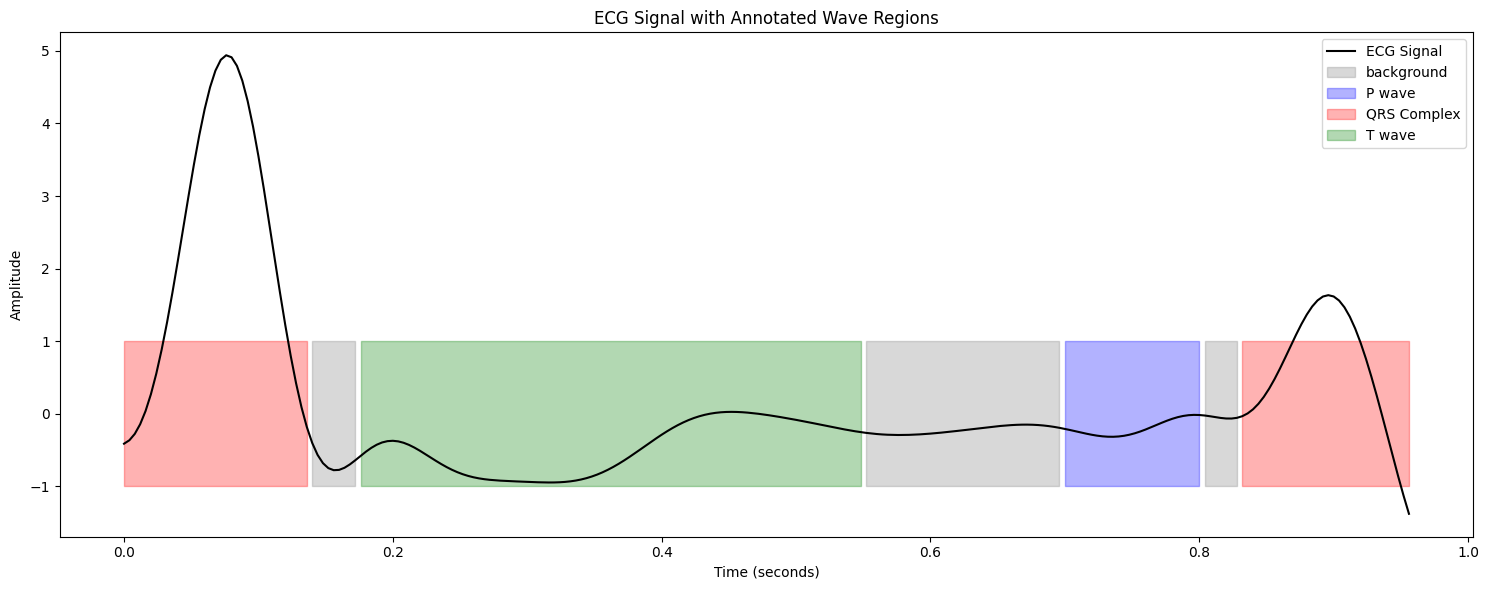

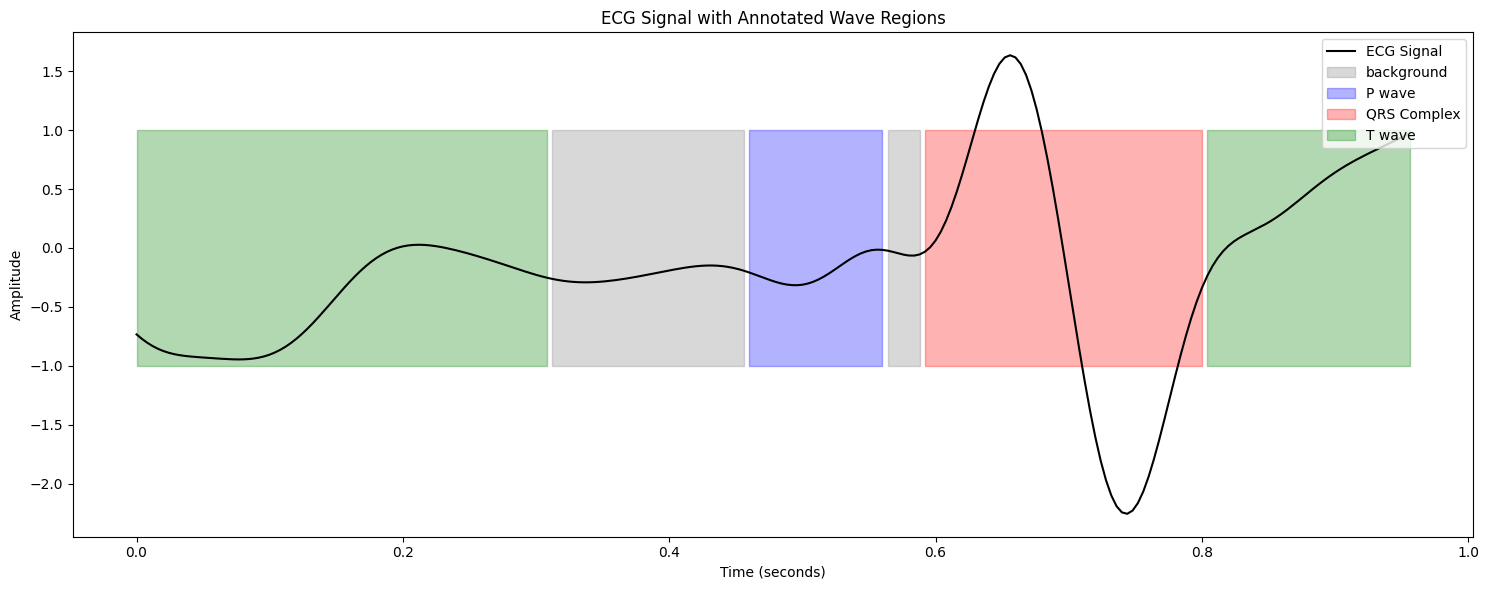

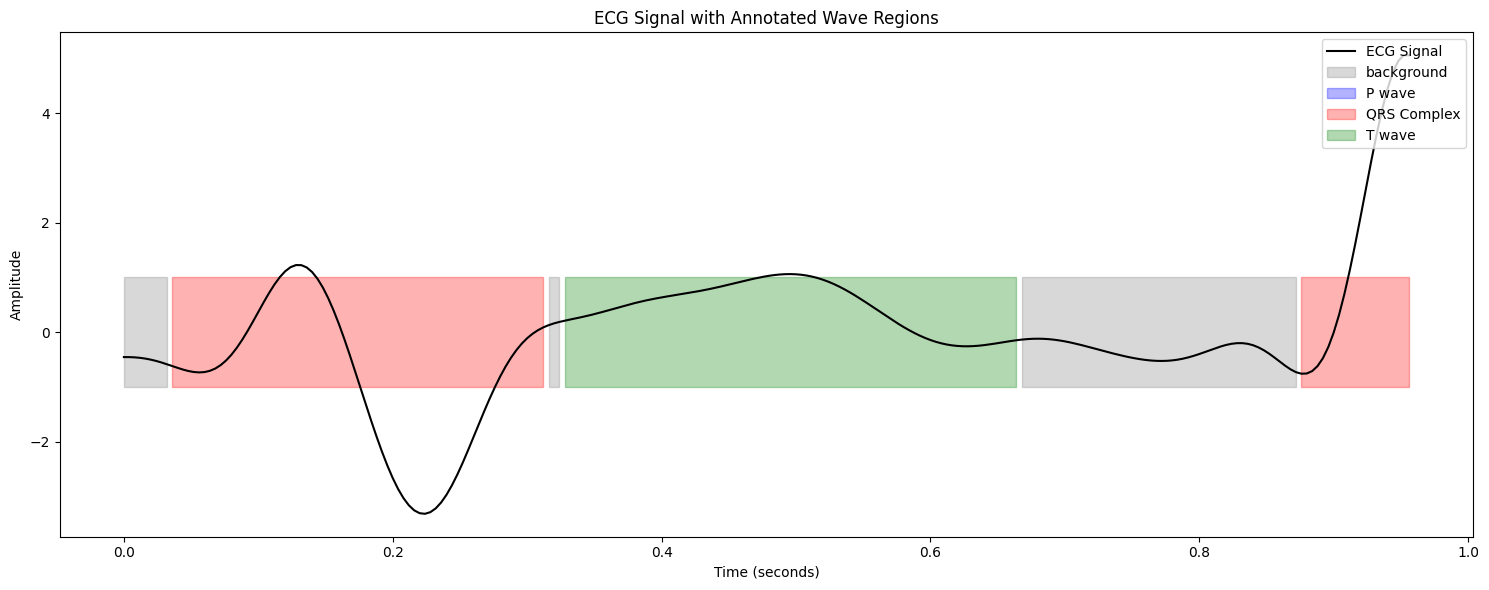

In [ ]:
from tqdm import tqdm
qt_segments_list, qt_masks_list = [], []

for record_path in tqdm(qt_records, desc="Processing QTDB Records"):
#if(True):
#    record_path = "sel232"
    try:

        #print(f"Processing {record_path}")
        segments, masks = process_record(qtdb_path+record_path, Type='QTDB', extra_ms={'p':0,'N':20,'t':0},target_fs=250)  # Resample to 250 Hz
        qt_segments_list.append(segments)
        qt_masks_list.append(masks)

    except:
        print(f"Skipping {record_path} due to error.")

display_ecg_with_masks(segments[0].flatten(), masks[0])
display_ecg_with_masks(segments[17].flatten(), masks[17])
display_ecg_with_masks(segments[18].flatten(), masks[18])
display_ecg_with_masks(segments[-1].flatten(), masks[-1])



Processing LUDB Records: 100%|██████████| 200/200 [00:01<00:00, 137.63it/s]


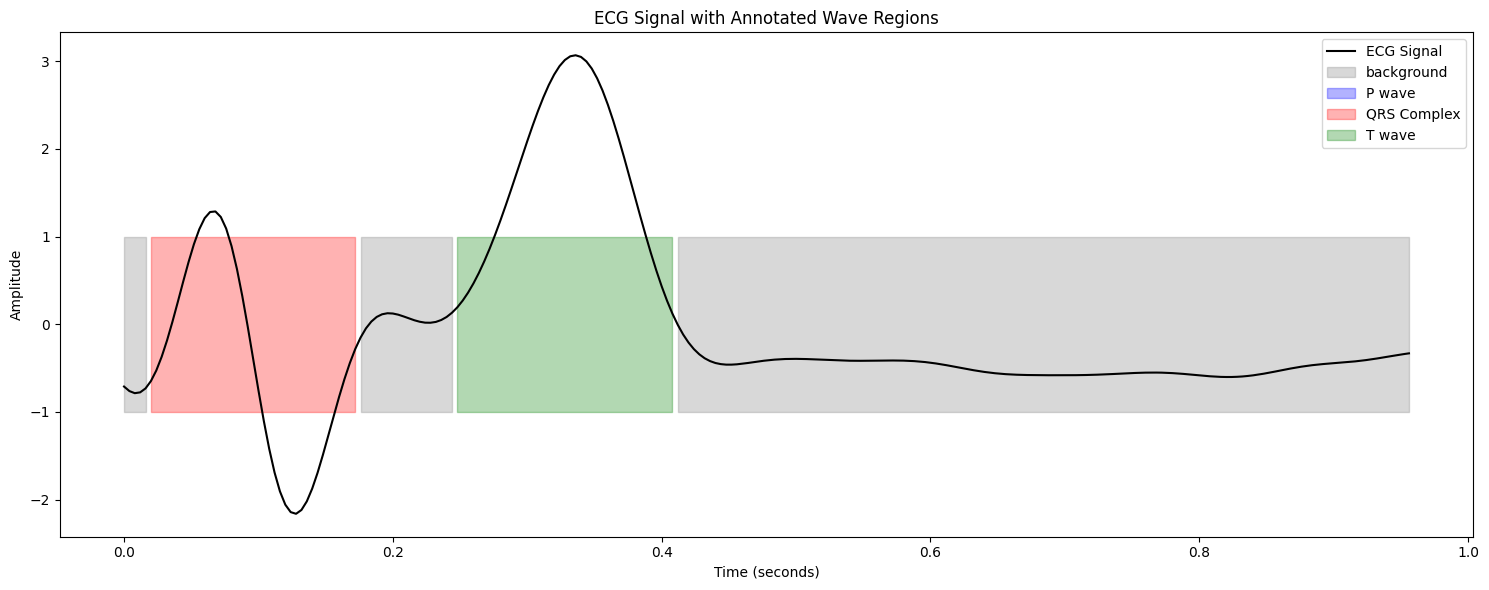

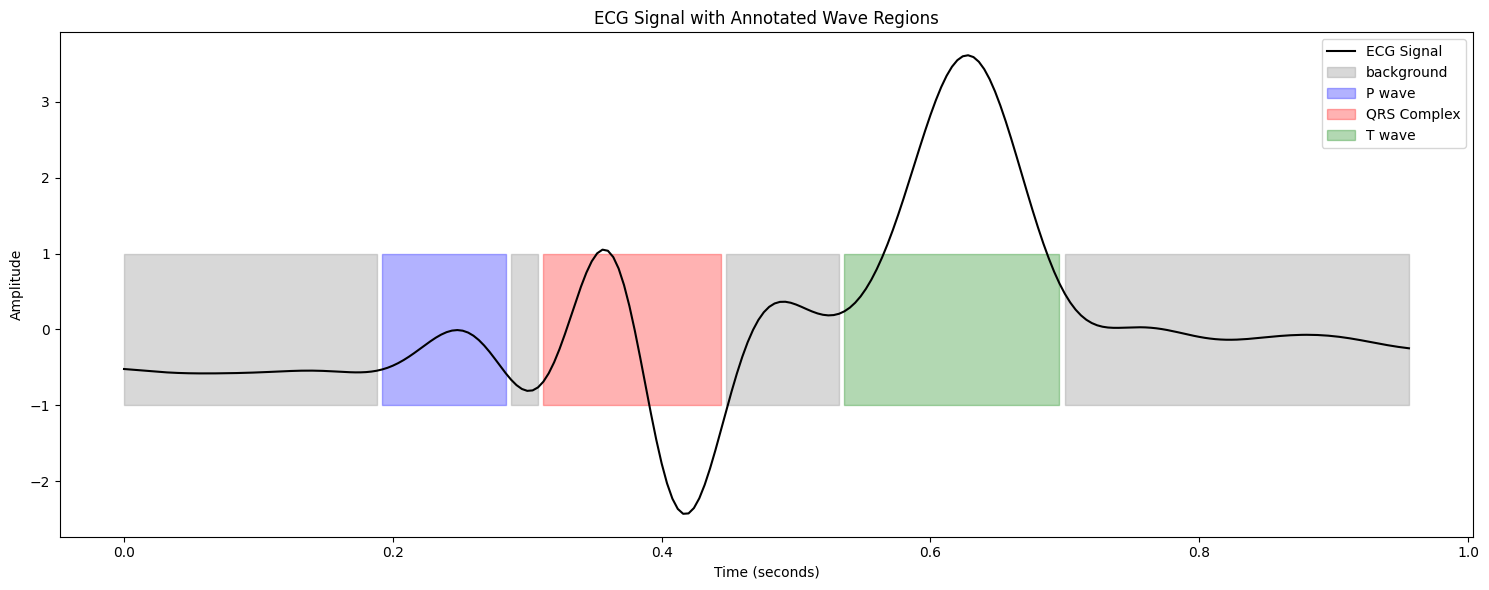

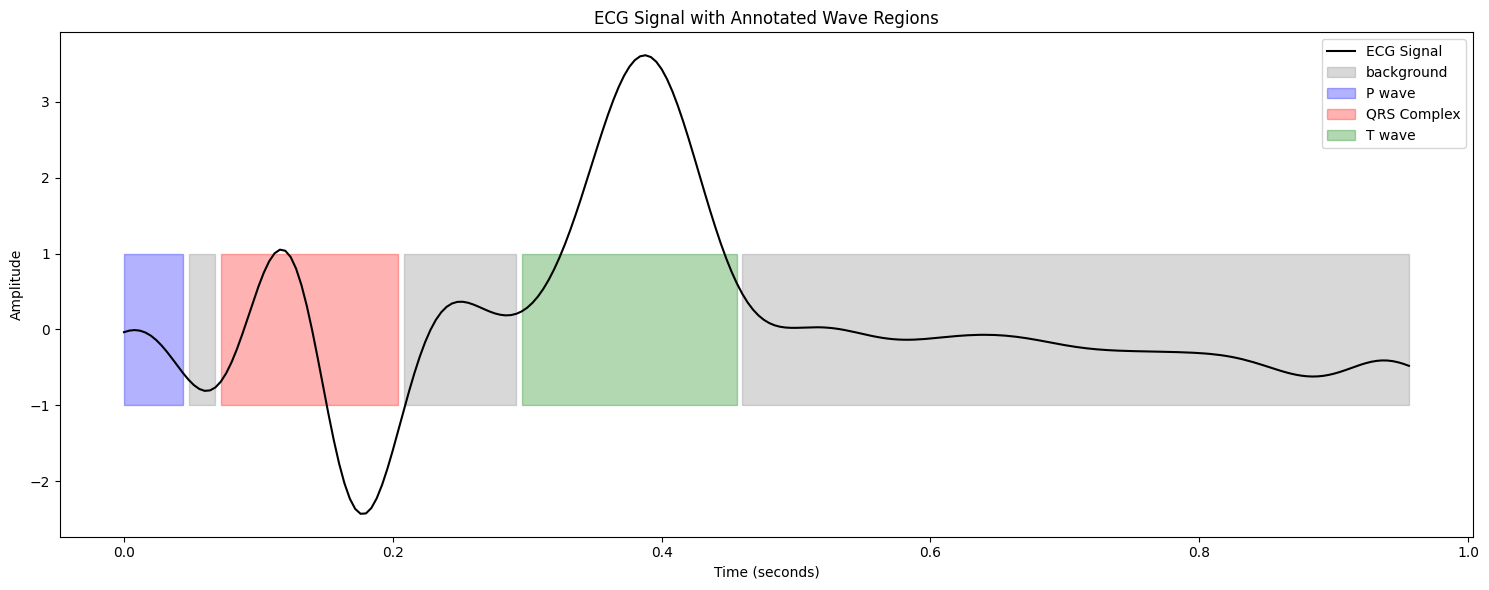

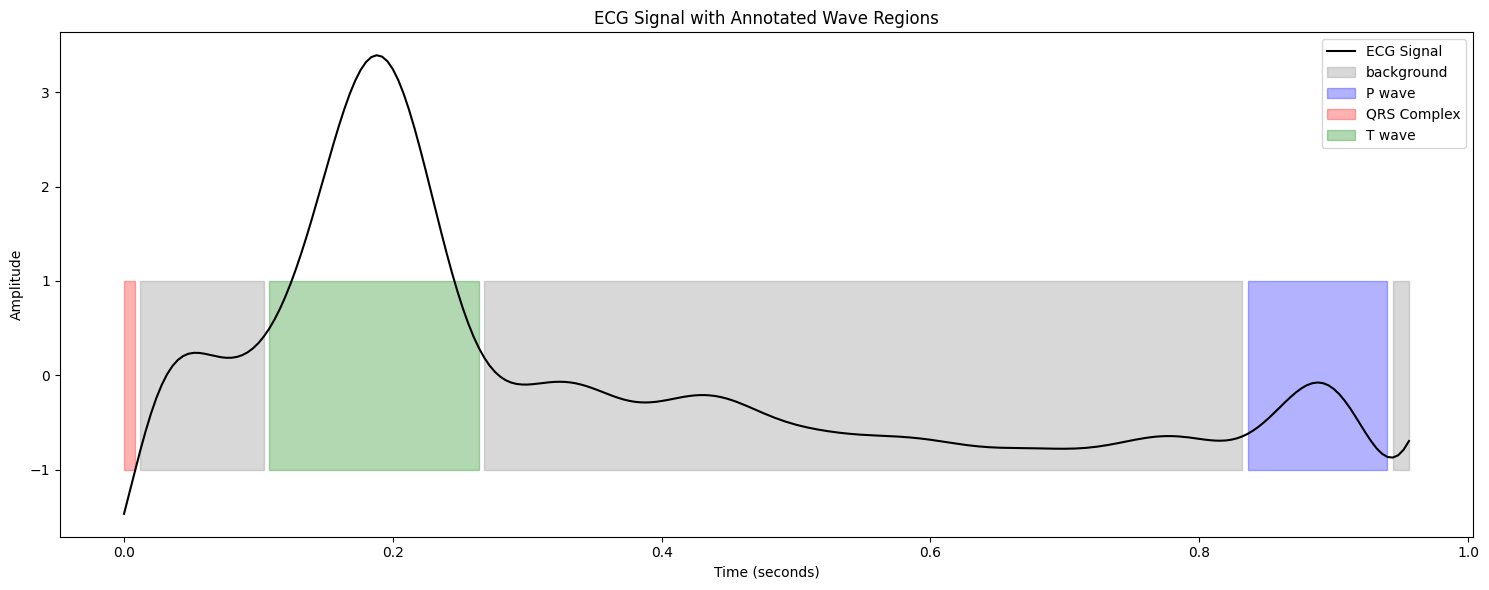

In [ ]:


lu_segments_list, lu_masks_list = [], []

for record_path in tqdm(lu_records, desc="Processing LUDB Records"):
    try:

        segments, masks = process_record(
            ludb_path + record_path,
            Type='LUDB',
            extra_ms={'p':0, 'N':20, 't':0},
            target_fs=250
        )
        lu_segments_list.append(segments)
        lu_masks_list.append(masks)

    except Exception as e:
        print(f"Skipping {record_path} due to error: {e}")




display_ecg_with_masks(segments[0].flatten(), masks[0])
display_ecg_with_masks(segments[17].flatten(), masks[17])
display_ecg_with_masks(segments[18].flatten(), masks[18])
display_ecg_with_masks(segments[-1].flatten(), masks[-1])

In [ ]:
qt_segments = np.concatenate(qt_segments_list, axis=0)
qt_masks = np.concatenate(qt_masks_list, axis=0)
lu_segments = np.concatenate(lu_segments_list, axis=0)
lu_masks = np.concatenate(lu_masks_list, axis=0)

In [ ]:
# Combine into final dataset
X = np.concatenate([qt_segments, lu_segments])

qt_segments = None
lu_segments = None
qt_segments_list = None
lu_segments_list = None

In [ ]:

y = np.concatenate([qt_masks, lu_masks])
print(y)

[[0 0 0 ... 0 0 0]
 [0 2 2 ... 0 0 0]
 [0 0 0 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [2 2 2 ... 0 0 0]]


In [ ]:
import numpy as np

# Flatten y to 1D
flat_y = y.flatten()

# Count occurrences of each class
unique_classes, class_counts = np.unique(flat_y, return_counts=True)

# Compute total number of labels
total_labels = np.sum(class_counts)

# Compute class weights
class_weights = class_counts / total_labels

# Display results
class_weight_dict = dict(zip(unique_classes, class_weights))
print("Class Counts:", dict(zip(unique_classes, class_counts)))
print("Class Weights (Relative Frequency):", class_weight_dict)

# Get weight of class 0
weight_0 = class_weight_dict.get(0, 0)
print(f"Weight of Class 0: {weight_0:.4f}")


Class Counts: {np.int64(0): np.int64(45861096), np.int64(1): np.int64(9742522), np.int64(2): np.int64(17298084), np.int64(3): np.int64(22661258)}
Class Weights (Relative Frequency): {np.int64(0): np.float64(0.47990451530593026), np.int64(1): np.float64(0.10194872574060075), np.int64(2): np.float64(0.1810124341062688), np.int64(3): np.float64(0.2371343248472002)}
Weight of Class 0: 0.4799


In [ ]:
qt_masks = None
lu_masks = None
qt_masks_list = None
lu_masks_list = None

# split dataset

In [ ]:
# Create train/test sets (e.g., 80/20 split)
from sklearn.model_selection import train_test_split

# First split 80% train, 20% temp (val + test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Then split 50/50 on temp → 10% val, 10% test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)


In [ ]:
from torch.utils.data import Dataset, DataLoader

class ECGWaveformDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.Y[idx], dtype=torch.long)

train_dataset = ECGWaveformDataset(X_train, y_train)
val_dataset = ECGWaveformDataset(X_val, y_val)
test_dataset = ECGWaveformDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)



In [ ]:
X=None
y=None

# model and training

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualConvBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, dilation=1):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3,
                              padding=dilation, dilation=dilation)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3,
                               padding=dilation, dilation=dilation)
        self.bn2 = nn.BatchNorm1d(out_channels)

        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        residual = self.shortcut(x)
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x += residual
        return F.relu(x)

class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Sequential(
            nn.Conv1d(F_g, F_int, kernel_size=1),
            nn.BatchNorm1d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv1d(F_l, F_int, kernel_size=1),
            nn.BatchNorm1d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv1d(F_int, 1, kernel_size=1),
            nn.BatchNorm1d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

class UNet1D_Enhanced(nn.Module):
    def __init__(self, in_channels=1, n_classes=4, base_filters=64):
        super().__init__()

        # Encoder with residual blocks and multi-scale context
        self.enc1 = ResidualConvBlock1D(in_channels, base_filters)
        self.pool1 = nn.MaxPool1d(2)

        self.enc2 = ResidualConvBlock1D(base_filters, base_filters*2)
        self.pool2 = nn.MaxPool1d(2)

        self.enc3 = ResidualConvBlock1D(base_filters*2, base_filters*4)
        self.pool3 = nn.MaxPool1d(2)

        self.enc4 = ResidualConvBlock1D(base_filters*4, base_filters*8)
        self.pool4 = nn.MaxPool1d(2)

        # Bottleneck with dilated convolution
        self.bottleneck = nn.Sequential(
            ResidualConvBlock1D(base_filters*8, base_filters*16, dilation=2),
            ResidualConvBlock1D(base_filters*16, base_filters*16, dilation=4)
        )

        # Decoder with attention gates
        self.upconv4 = nn.ConvTranspose1d(base_filters*16, base_filters*8, kernel_size=2, stride=2)
        self.att4 = AttentionBlock(base_filters*8, base_filters*8, base_filters//2)
        self.dec4 = ResidualConvBlock1D(base_filters*16, base_filters*8)

        self.upconv3 = nn.ConvTranspose1d(base_filters*8, base_filters*4, kernel_size=2, stride=2)
        self.att3 = AttentionBlock(base_filters*4, base_filters*4, base_filters//4)
        self.dec3 = ResidualConvBlock1D(base_filters*8, base_filters*4)

        self.upconv2 = nn.ConvTranspose1d(base_filters*4, base_filters*2, kernel_size=2, stride=2)
        self.att2 = AttentionBlock(base_filters*2, base_filters*2, base_filters//8)
        self.dec2 = ResidualConvBlock1D(base_filters*4, base_filters*2)

        self.upconv1 = nn.ConvTranspose1d(base_filters*2, base_filters, kernel_size=2, stride=2)
        self.att1 = AttentionBlock(base_filters, base_filters, base_filters//16)
        self.dec1 = ResidualConvBlock1D(base_filters*2, base_filters)

        # Output with multi-scale feature fusion
        self.final_conv = nn.Sequential(
            nn.Conv1d(base_filters, base_filters//2, kernel_size=3, padding=1),
            nn.BatchNorm1d(base_filters//2),
            nn.ReLU(),
            nn.Conv1d(base_filters//2, n_classes, kernel_size=1)
        )

        # Boundary refinement
        self.boundary_refine = nn.Conv1d(n_classes, n_classes, kernel_size=5, padding=2)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(self.pool3(e3))

        # Bottleneck
        b = self.bottleneck(self.pool4(e4))

        # Decoder with attention
        d4 = self.upconv4(b)
        e4 = self.att4(d4, center_crop(e4, d4.shape[-1]))
        d4 = self.dec4(torch.cat([d4, e4], dim=1))

        d3 = self.upconv3(d4)
        e3 = self.att3(d3, center_crop(e3, d3.shape[-1]))
        d3 = self.dec3(torch.cat([d3, e3], dim=1))

        d2 = self.upconv2(d3)
        e2 = self.att2(d2, center_crop(e2, d2.shape[-1]))
        d2 = self.dec2(torch.cat([d2, e2], dim=1))

        d1 = self.upconv1(d2)
        e1 = self.att1(d1, center_crop(e1, d1.shape[-1]))
        d1 = self.dec1(torch.cat([d1, e1], dim=1))

        # Output
        out = self.final_conv(d1)

        # Boundary refinement
        out = out + self.boundary_refine(out)  # Residual connection

        return out

def center_crop(enc_feat, target_size):
    _, _, L = enc_feat.size()
    diff = L - target_size
    if diff == 0:
        return enc_feat
    start = diff // 2
    end = start + target_size
    return enc_feat[:, :, start:end]

In [ ]:
import torch
import random
import torch.nn.functional as F

class ECGAugment:
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, x, y):
        """
        x: ECG signal (batch_size, 1, sequence_length)
        y: Segmentation mask (batch_size, sequence_length)
        """
        if len(x.shape) != 3:
            raise ValueError(f"Expected 3D input (B,1,L), got {x.shape}")
        if len(y.shape) != 2:
            raise ValueError(f"Expected 2D mask (B,L), got {y.shape}")

        batch_size, _, seq_len = x.shape

        # Random scaling
        if random.random() < self.p:
            scale = torch.empty(batch_size, 1, 1).uniform_(0.9, 1.1).to(x.device)
            x = x * scale

        # Add Gaussian noise
        if random.random() < self.p:
            x = x + torch.randn_like(x) * 0.01

        # Random time warping
        if random.random() < self.p:
            new_len = random.randint(int(seq_len*0.95), int(seq_len*1.05))

            # Reshape for interpolation (B,1,L) -> (B*1,L) -> (B*1,1,L)
            x_reshaped = x.view(-1, seq_len).unsqueeze(1)
            x_warped = F.interpolate(x_reshaped, size=new_len,
                                   mode='linear', align_corners=True)
            x_warped = F.interpolate(x_warped, size=seq_len,
                                   mode='linear', align_corners=True)
            x = x_warped.view(batch_size, 1, seq_len)

            # Reshape mask (B,L) -> (B,1,L)
            y_reshaped = y.float().unsqueeze(1)
            y_warped = F.interpolate(y_reshaped, size=new_len,
                                   mode='nearest')
            y_warped = F.interpolate(y_warped, size=seq_len,
                                   mode='nearest')
            y = y_warped.squeeze(1).long()

        return x, y

In [ ]:
def compute_per_class_loss(output, target, num_classes=4):
    """ Compute loss per class for analysis. """
    per_class_loss = torch.zeros(num_classes, device=device)
    log_probs = F.log_softmax(output, dim=1)  # Convert output to log probabilities

    for cls in range(num_classes):
        mask = (target == cls)  # Mask for class cls
        if mask.sum() > 0:  # Avoid empty class issue
            cls_loss = -log_probs[:, cls, :][mask].mean()  # Compute log loss
            per_class_loss[cls] = cls_loss

    return per_class_loss

def compute_loss_and_metrics(output, target):
    """Compute focal loss and metrics"""
    # Focal loss calculation
    log_probs = F.log_softmax(output, dim=1)
    probs = torch.exp(log_probs)

    # Gather the probabilities of the target classes
    target_probs = probs.gather(1, target.unsqueeze(1)).squeeze(1)
    focal_term = -((1 - target_probs) ** 2.0) * log_probs.gather(1, target.unsqueeze(1)).squeeze(1)

    # Apply class weights
    weights = class_weights.gather(0, target.view(-1)).view_as(focal_term)
    loss = (focal_term * weights).mean()

    # Per-class loss
    per_class_loss = torch.zeros(4, device=device)
    for cls in range(4):
        mask = (target == cls)
        if mask.sum() > 0:
            per_class_loss[cls] = focal_term[mask].mean()

    # Metrics calculation
    preds = torch.argmax(output, dim=1)
    acc = (preds == target).float().mean()

    # Per-class IoU
    ious = torch.zeros(4, device=device)
    for cls in range(4):
        intersection = ((preds == cls) & (target == cls)).sum()
        union = ((preds == cls) | (target == cls)).sum()
        ious[cls] = intersection / (union + 1e-8)

    return loss, per_class_loss, acc.item(), ious


In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        """
        alpha: Weighting factor per class (Tensor)
        gamma: Focusing parameter (higher values down-weight easy examples)
        """
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        # Convert inputs to probabilities
        log_probs = F.log_softmax(inputs, dim=1)
        probs = torch.exp(log_probs)

        # Gather the probabilities of the target classes
        B, C, L = inputs.shape
        targets = targets.unsqueeze(1)  # (B, 1, L)
        class_probs = probs.gather(1, targets).squeeze(1)  # (B, L)

        # Compute focal loss
        focal = -((1 - class_probs) ** self.gamma) * log_probs.gather(1, targets).squeeze(1)

        # Apply class weights if provided
        if self.alpha is not None:
            alpha_weight = self.alpha.gather(0, targets.view(-1)).view_as(focal)
            focal = focal * alpha_weight

        # Reduce loss
        if self.reduction == 'mean':
            return focal.mean()
        elif self.reduction == 'sum':
            return focal.sum()
        else:
            return focal

In [ ]:
import torch.nn as nn
import torch.optim as optim



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model
model = UNet1D_Enhanced(n_classes=4).to(device)

# Initialize augmentations
augmenter = ECGAugment(p=0.5)  # 50% probability per augmentation

# Initialize loss with class weights
class_weights = torch.tensor([0.3, 0.3, 0.25, 0.15], device=device)
best_weights = class_weights.clone()
best_val_loss = float('inf')

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)


In [ ]:
def update_weights(val_class_loss, momentum=0.8, min_weight=0.1):
    """Update class weights with stability controls"""
    global class_weights, best_weights, best_val_loss

    # Calculate new weights
    new_weights = val_class_loss / val_class_loss.sum()
    new_weights = torch.clamp(new_weights, min_weight, 1.0)  # Constrain weights
    new_weights = new_weights / new_weights.sum()  # Renormalize

    # Apply momentum
    class_weights = momentum * class_weights + (1 - momentum) * new_weights

    # Save best weights
    current_val_loss = val_class_loss.mean()
    if current_val_loss < best_val_loss:
        best_val_loss = current_val_loss
        best_weights = class_weights.clone()


In [ ]:
def train_epoch(train_loader):
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    epoch_ious = torch.zeros(4, device=device)

    for X_batch, y_batch in tqdm(train_loader, desc="Training"):
        # Ensure proper dimensions
        if len(X_batch.shape) == 2:  # (B,L) -> (B,1,L)
            X_batch = X_batch.unsqueeze(1)
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Apply augmentations
        X_batch, y_batch = augmenter(X_batch, y_batch)

        optimizer.zero_grad()
        output = model(X_batch)  # (B,4,L)

        # Compute loss and metrics
        loss, class_loss, acc, ious = compute_loss_and_metrics(output, y_batch)

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc
        epoch_ious += ious

    return epoch_loss/len(train_loader), epoch_acc/len(train_loader), epoch_ious/len(train_loader)
def evaluate(val_loader):
    model.eval()
    val_loss = 0
    val_acc = 0
    val_ious = torch.zeros(4, device=device)
    val_class_loss = torch.zeros(4, device=device)

    with torch.no_grad():
        for X_batch, y_batch in tqdm(val_loader, desc="Validating"):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            output = model(X_batch)

            loss, class_loss, acc, ious = compute_loss_and_metrics(output, y_batch)

            val_loss += loss.item()
            val_acc += acc
            val_ious += ious
            val_class_loss += class_loss * len(X_batch)

    avg_class_loss = val_class_loss / len(val_loader.dataset)
    return (val_loss/len(val_loader), val_acc/len(val_loader),
            val_ious/len(val_loader), avg_class_loss)

In [ ]:
def train(train_loader, val_loader, epochs=50):
    for epoch in range(epochs):
        train_loss, train_acc, train_ious = train_epoch(train_loader)
        val_loss, val_acc, val_ious, val_class_loss = evaluate(val_loader)

        scheduler.step(val_loss)
        update_weights(val_class_loss)

        print(f"\nEpoch {epoch+1}/{epochs}:")
        print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f} | IoU: {train_ious.cpu().numpy()}")
        print(f"Val Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | IoU: {val_ious.cpu().numpy()}")
        print(f"Class Losses: {val_class_loss.cpu().numpy()}")
        print(f"Class Weights: {class_weights.cpu().numpy()}")

In [ ]:
train(train_loader, val_loader, epochs=12)


Validating: 100%|██████████| 1867/1867 [00:22<00:00, 82.21it/s]



Epoch 1/12:
Train Loss: 0.0204 | Acc: 0.8929 | IoU: [0.81215835 0.7319203  0.8727653  0.7816227 ]
Val Loss: 0.0162 | Acc: 0.9141 | IoU: [0.84522015 0.7732044  0.8945453  0.8260095 ]
Class Losses: [0.04701731 0.10631108 0.06068764 0.09600554]
Class Weights: [0.27033165 0.30858302 0.2391506  0.18193474]


Validating: 100%|██████████| 1867/1867 [00:22<00:00, 82.88it/s]



Epoch 2/12:
Train Loss: 0.0165 | Acc: 0.9121 | IoU: [0.8398669  0.7698144  0.8978942  0.82321066]
Val Loss: 0.0152 | Acc: 0.9199 | IoU: [0.8525608  0.77721685 0.91039205 0.84014904]
Class Losses: [0.04734757 0.09883658 0.05330127 0.08356124]
Class Weights: [0.24972099 0.3167041  0.22898301 0.20459194]


Validating: 100%|██████████| 1867/1867 [00:22<00:00, 82.93it/s]



Epoch 3/12:
Train Loss: 0.0158 | Acc: 0.9157 | IoU: [0.84487563 0.77695364 0.902086   0.8325279 ]
Val Loss: 0.0155 | Acc: 0.9166 | IoU: [0.8460907  0.77884984 0.89539516 0.8394561 ]
Class Losses: [0.05382497 0.09233095 0.06300119 0.07094442]
Class Weights: [0.23820928 0.31929004 0.22817095 0.21432978]


Validating: 100%|██████████| 1867/1867 [00:22<00:00, 82.61it/s]



Epoch 4/12:
Train Loss: 0.0154 | Acc: 0.9172 | IoU: [0.84692097 0.7798824  0.9040927  0.83660316]
Val Loss: 0.0148 | Acc: 0.9189 | IoU: [0.8491407  0.7841807  0.9068933  0.83991516]
Class Losses: [0.05352592 0.09365591 0.05870336 0.06331539]
Class Weights: [0.23033398 0.3250128  0.22614987 0.2185034 ]


Validating: 100%|██████████| 1867/1867 [00:22<00:00, 83.49it/s]



Epoch 5/12:
Train Loss: 0.0151 | Acc: 0.9178 | IoU: [0.84762716 0.78115624 0.90506095 0.8379628 ]
Val Loss: 0.0145 | Acc: 0.9220 | IoU: [0.85376257 0.7906837  0.90593165 0.8499014 ]
Class Losses: [0.06228538 0.09225164 0.04489796 0.0518294 ]
Class Weights: [0.23384476 0.33344018 0.21665752 0.2160576 ]


Validating: 100%|██████████| 1867/1867 [00:22<00:00, 82.90it/s]



Epoch 6/12:
Train Loss: 0.0150 | Acc: 0.9183 | IoU: [0.8486482  0.78274393 0.90553206 0.8387976 ]
Val Loss: 0.0143 | Acc: 0.9225 | IoU: [0.8560733  0.79142773 0.9067517  0.84948605]
Class Losses: [0.05366305 0.07917308 0.05485538 0.06705976]
Class Weights: [0.22920558 0.3289093  0.21639185 0.22549333]


Validating: 100%|██████████| 1867/1867 [00:22<00:00, 83.16it/s]



Epoch 7/12:
Train Loss: 0.0149 | Acc: 0.9188 | IoU: [0.8492244  0.78377914 0.9061071  0.8401163 ]
Val Loss: 0.0143 | Acc: 0.9212 | IoU: [0.85058916 0.79012156 0.9134232  0.84636134]
Class Losses: [0.064438   0.08213393 0.0459372  0.04963231]
Class Weights: [0.23658791 0.33096707 0.21105593 0.22138914]


Training:  79%|███████▉  | 7868/9955 [07:41<02:02, 17.04it/s]


KeyboardInterrupt: 

In [ ]:
train(train_loader, val_loader, epochs=4)


Validating: 100%|██████████| 1867/1867 [00:22<00:00, 83.72it/s]



Epoch 1/4:
Train Loss: 0.0149 | Acc: 0.9192 | IoU: [0.85019517 0.7854535  0.9065004  0.84016746]
Val Loss: 0.0139 | Acc: 0.9259 | IoU: [0.8629176  0.79539144 0.9153017  0.8501722 ]
Class Losses: [0.04516093 0.10059589 0.04802477 0.06641368]
Class Weights: [0.22398344 0.34209704 0.20575915 0.22816041]


Validating: 100%|██████████| 1867/1867 [00:22<00:00, 83.06it/s]



Epoch 2/4:
Train Loss: 0.0146 | Acc: 0.9192 | IoU: [0.84965026 0.78449833 0.9069076  0.8414428 ]
Val Loss: 0.0150 | Acc: 0.9146 | IoU: [0.84281725 0.77585    0.9034741  0.8295741 ]
Class Losses: [0.05576067 0.06490976 0.06184601 0.08215412]
Class Weights: [0.22132266 0.3227271  0.21134166 0.24460863]


Validating: 100%|██████████| 1867/1867 [00:22<00:00, 83.18it/s]



Epoch 3/4:
Train Loss: 0.0147 | Acc: 0.9194 | IoU: [0.8498748 0.7860851 0.9070902 0.8417583]
Val Loss: 0.0147 | Acc: 0.9196 | IoU: [0.8532625  0.79557484 0.90154356 0.83494776]
Class Losses: [0.04819063 0.08757494 0.05898487 0.07675843]
Class Weights: [0.21255651 0.3226915  0.21252301 0.25222903]


Validating: 100%|██████████| 1867/1867 [00:22<00:00, 83.72it/s]


Epoch 4/4:
Train Loss: 0.0145 | Acc: 0.9193 | IoU: [0.8493068 0.785238  0.9075369 0.8422946]
Val Loss: 0.0138 | Acc: 0.9252 | IoU: [0.8613712  0.79803    0.9113968  0.85118717]
Class Losses: [0.04668995 0.08571434 0.06011569 0.06487224]
Class Weights: [0.20632443 0.3247553  0.21672978 0.25219053]


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def test(model, test_loader):
    model.eval()

    test_acc = 0.0

    with torch.no_grad():
        for i, (X_batch, y_batch) in enumerate(test_loader):
            X_batch = X_batch.to(device)  # shape: (1, 1, L)

            # Handle label shape
            if y_batch.dim() == 3 and y_batch.shape[-1] > 1:
                y_batch = y_batch.argmax(dim=2)
            y_batch = y_batch.to(device)  # shape: (1, L)

            output = model(X_batch)       # shape: (1, C, L)
            preds = torch.argmax(output, dim=1)  # shape: (1, L)

            acc = (preds == y_batch).float().mean()
            test_acc += acc.item()

            # === Visualization ===
            if i == 0:  # plot first sample
                signal = X_batch[0, 0].cpu().numpy()
                pred_mask = preds[0].cpu().numpy()
                true_mask = y_batch[0].cpu().numpy()
                time = np.arange(len(signal))

                plt.figure(figsize=(15, 6))
                plt.plot(time, signal, color='black', label='ECG Signal')

                # Plot predictions
                for class_idx, color, label in zip([1, 2, 3], ['blue', 'red', 'green'], ['P', 'QRS', 'T']):
                    plt.fill_between(time, -1, 1, where=pred_mask == class_idx, color=color, alpha=0.3, label=f'Predicted {label}')
                    plt.fill_between(time, -1, 1, where=true_mask == class_idx, color=color, alpha=0.1, label=f'True {label}', linestyle='dashed')

                plt.title('Predicted vs Ground Truth Mask on Test Sample')
                plt.xlabel('Time (samples)')
                plt.ylabel('Amplitude')
                plt.legend(loc='upper right')
                plt.tight_layout()
                plt.show()

    avg_acc = test_acc / len(test_loader)
    print(f"✅ Test Accuracy: {avg_acc * 100:.2f}%")

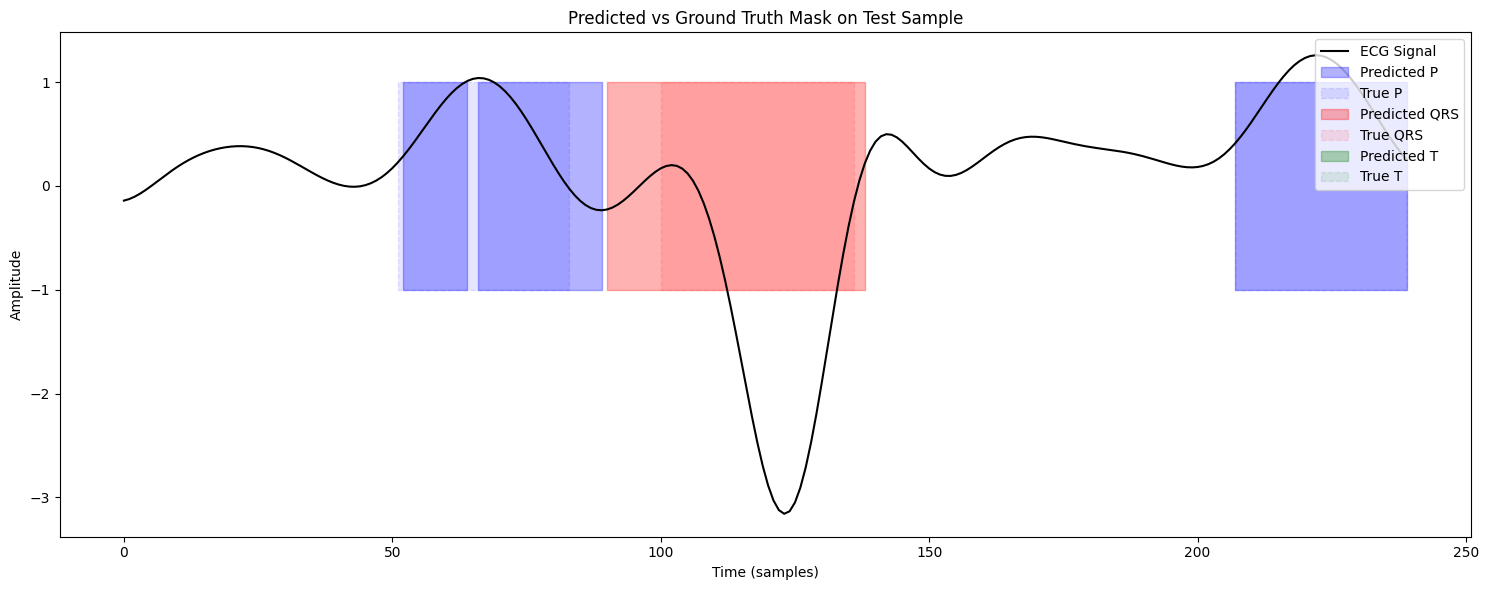

✅ Test Accuracy: 92.45%


In [ ]:
test(model, test_loader)


In [ ]:
torch.save(model.state_dict(), "./unet1d_ecg_qrs.pth")


# testing model on ecg signal

In [ ]:
model = UNet1D(n_classes=4)
model.load_state_dict(torch.load("unet1d_ecg_qrs.pth", map_location=device))
model.to(device)
model.eval()


UNet1D(
  (enc1): ConvBlock1D(
    (block): Sequential(
      (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): ConvBlock1D(
    (block): Sequential(
      (0): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (pool2): MaxPool

In [ ]:
def predict_full_ecg(signal, model, fs=250, window_size=240):
    model.eval()
    signal = signal[:len(signal) - (len(signal) % window_size)]  # crop to multiple of window_size
    signal = normalize_signal(smooth_signal(bandpass_filter(signal, fs=fs)))
    signal = signal.reshape(1, 1, -1)  # (1, 1, L)

    segments = []
    for i in range(0, signal.shape[2] - window_size + 1, window_size):
        window = signal[:, :, i:i+window_size]
        segments.append(window)

    predictions = []
    with torch.no_grad():
        for window in segments:
            window = torch.tensor(window, dtype=torch.float32).to(device)
            output = model(window)  # (1, C, L)
            pred = torch.argmax(output, dim=1).cpu().numpy()[0]  # (L,)
            predictions.append(pred)

    full_prediction = np.concatenate(predictions)
    return full_prediction


In [ ]:
def get_wave_boundaries(predicted_labels):
    wave_types = {1: 'P', 2: 'QRS', 3: 'T'}
    wave_boundaries = {k: [] for k in wave_types.values()}

    current_class = None
    start = None

    for i, label in enumerate(predicted_labels):
        if label in wave_types:
            if current_class is None:
                current_class = label
                start = i
            elif label != current_class:
                wave_boundaries[wave_types[current_class]].append((start, i-1))
                current_class = label
                start = i
        else:

            if current_class is not None:
                wave_boundaries[wave_types[current_class]].append((start, i-1))
                current_class = None
                start = None

    # Handle last segment
    if current_class is not None:
        wave_boundaries[wave_types[current_class]].append((start, len(predicted_labels)-1))

    return wave_boundaries


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_boundaries(signal, boundaries, fs=250, zoom=(0, None)):
    time = np.arange(len(signal)) / fs  # in seconds

    plt.figure(figsize=(18, 6))
    plt.plot(time, signal, color='black', label='ECG Signal', linewidth=1)

    wave_colors = {'P': 'blue', 'QRS': 'red', 'T': 'green'}

    for wave_type, regions in boundaries.items():
        for start, end in regions:
            plt.fill_between(
                time[start:end],
                -1, 1,
                color=wave_colors.get(wave_type, 'gray'),
                alpha=0.3,
                label=f'Predicted {wave_type}'
            )

    # Prevent duplicate labels in legend
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc='upper right')

    plt.title("ECG Signal with Predicted Wave Regions", fontsize=16)
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.tight_layout()

    # Optional zoom
    if zoom[1] is None:
        plt.xlim(zoom[0], time[-1])
    else:
        plt.xlim(zoom)

    plt.show()


{'P': [(299, 303), (308, 312), (595, 612), (880, 900), (1168, 1187), (1699, 1705), (2043, 2048), (2343, 2348), (2640, 2649), (2923, 2931), (3213, 3217), (3224, 3230), (3435, 3451), (3744, 3763), (3810, 3815), (4081, 4094), (4388, 4406), (4684, 4692), (4696, 4700), (4976, 4984), (4988, 4989), (5519, 5523), (5785, 5815), (6126, 6126), (6138, 6138), (6429, 6449), (7022, 7030), (7036, 7040), (7311, 7331), (7550, 7570), (7833, 7833), (7837, 7847), (8776, 8784), (8789, 8789)], 'QRS': [(0, 9), (28, 34), (288, 298), (304, 307), (313, 314), (322, 359), (364, 367), (587, 594), (613, 665), (879, 879), (906, 950), (1164, 1167), (1194, 1233), (1440, 1485), (1722, 1787), (2037, 2042), (2049, 2112), (2334, 2342), (2349, 2404), (2622, 2639), (2659, 2684), (2701, 2702), (2917, 2922), (2932, 2992), (3204, 3212), (3218, 3223), (3238, 3282), (3483, 3536), (3768, 3795), (4077, 4079), (4112, 4116), (4378, 4387), (4414, 4459), (4676, 4683), (4693, 4695), (4701, 4702), (4709, 4751), (4973, 4975), (4985, 4987)

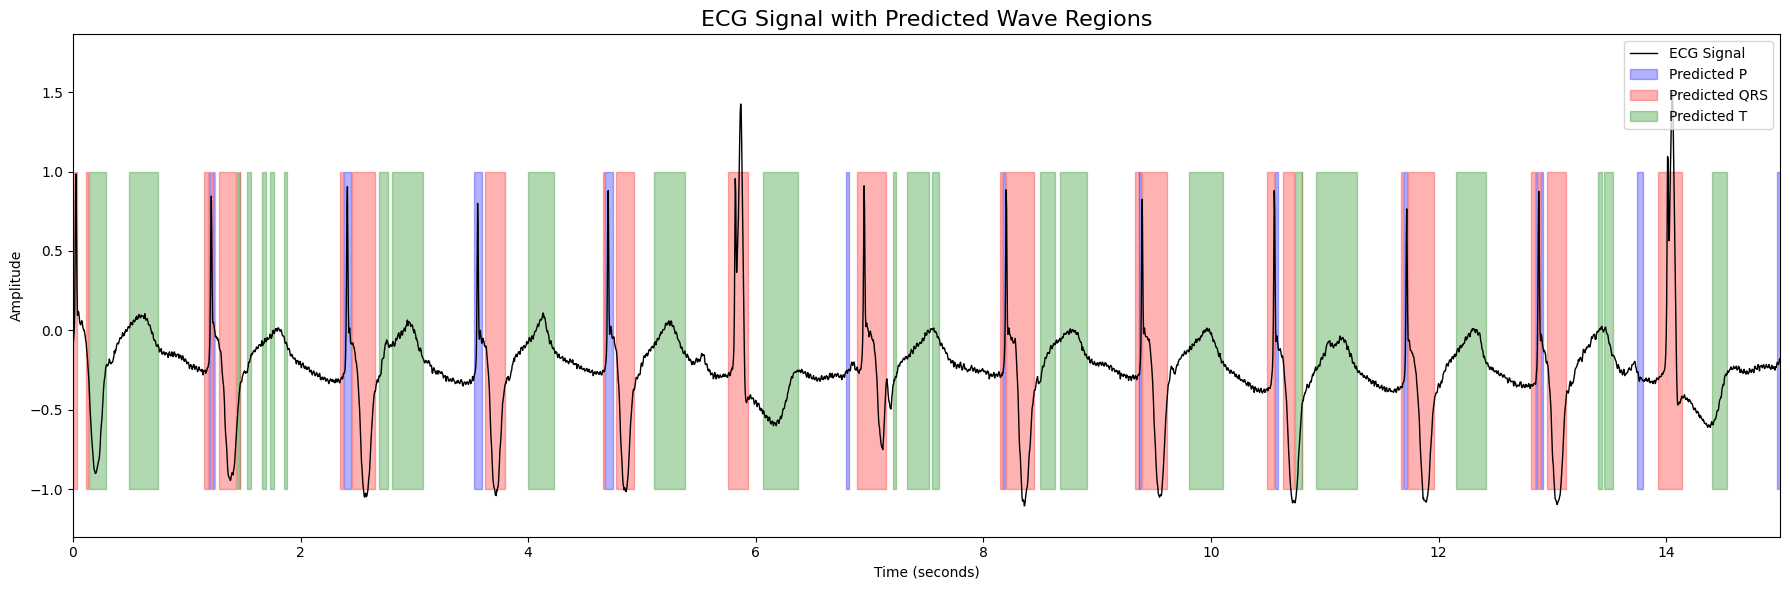

In [ ]:
# Load your test signal (e.g., from wfdb)
#record = wfdb.rdrecord('/content/drive/MyDrive/Final project/dataset/physionet.org/files/ecgiddb/1.0.0/Person_48/rec_1')
record = wfdb.rdrecord(path+'/physionet.org/files/mitdb/1.0.0/104')
signal = record.p_signal[:, 0]  # lead I
fs = record.fs
signal=signal[(10):(25*fs)]

# Predict
pred_labels = predict_full_ecg(signal, model, fs=250)

# Extract wave start/end
boundaries = get_wave_boundaries(pred_labels)
print(boundaries)
visualize_boundaries(signal, boundaries, fs=250, zoom=(0, 15))

{'P': [(490, 514), (764, 793), (1036, 1061), (1304, 1326), (1572, 1596), (1838, 1860), (2119, 2135), (2400, 2404), (2645, 2673), (2916, 2945), (3183, 3215), (3459, 3485), (3726, 3753), (3994, 4023), (4272, 4297), (4544, 4572), (4815, 4843), (5095, 5119), (5366, 5392), (5644, 5662), (5906, 5934), (6184, 6209), (6480, 6491), (6734, 6758), (7011, 7040), (7287, 7319), (7567, 7590), (7842, 7867), (8111, 8139), (8400, 8415), (8678, 8696)], 'QRS': [(0, 24), (250, 285), (530, 565), (804, 841), (1076, 1107), (1341, 1372), (1608, 1642), (1880, 1912), (2153, 2183), (2417, 2452), (2688, 2721), (2956, 2990), (3228, 3258), (3498, 3533), (3767, 3798), (4036, 4070), (4316, 4348), (4582, 4618), (4853, 4890), (5135, 5167), (5405, 5440), (5676, 5709), (5944, 5981), (6225, 6258), (6504, 6535), (6772, 6805), (7053, 7088), (7330, 7362), (7607, 7635), (7880, 7912), (8156, 8186), (8428, 8461), (8711, 8740)], 'T': [(63, 113), (326, 381), (610, 663), (886, 939), (1151, 1203), (1414, 1468), (1685, 1741), (1956, 

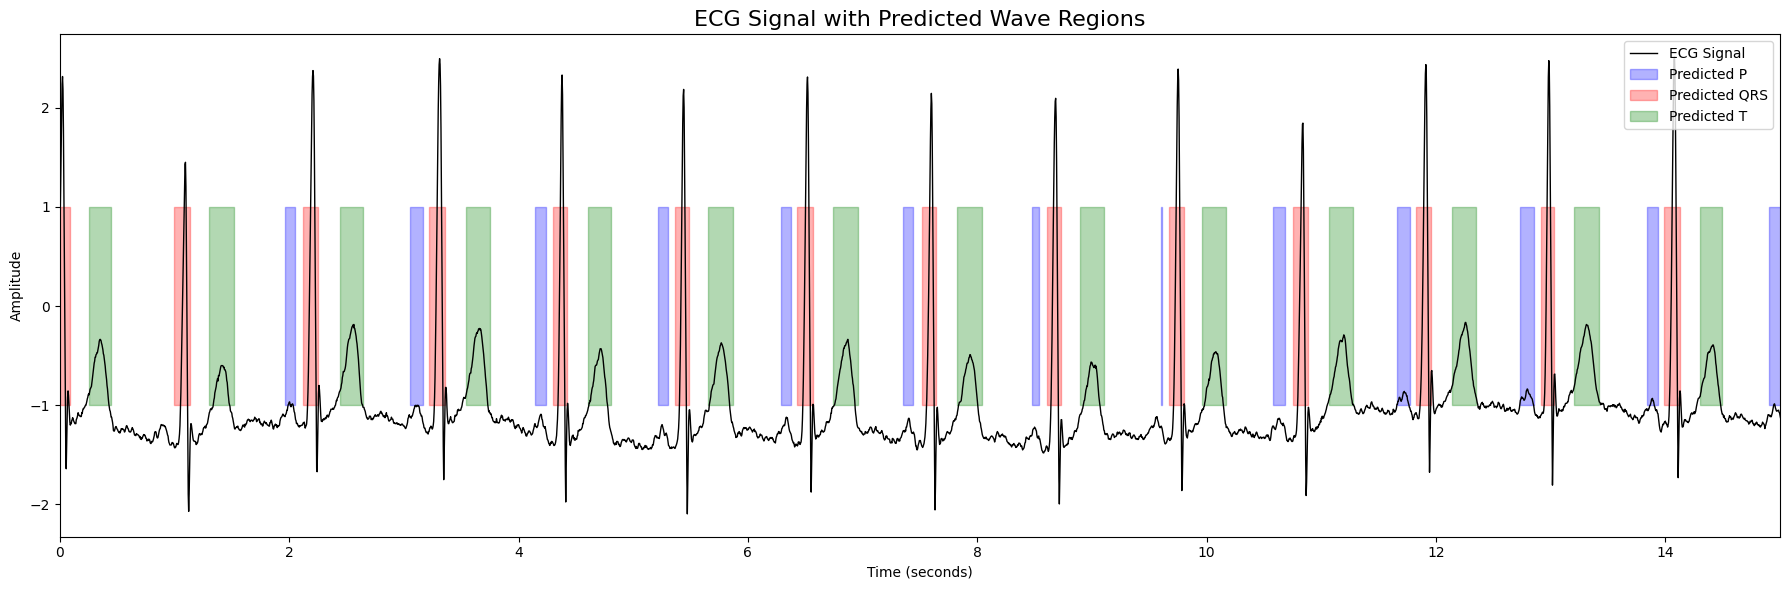

In [ ]:
# Load your test signal (e.g., from wfdb)
#record = wfdb.rdrecord('/content/drive/MyDrive/Final project/dataset/physionet.org/files/ecgiddb/1.0.0/Person_48/rec_1')
record = wfdb.rdrecord(path+'/physionet.org/files/mitdb/1.0.0/116')
signal = record.p_signal[:, 0]  # lead I
fs = record.fs
signal=signal[(10):(25*fs)]

# Predict
pred_labels = predict_full_ecg(signal, model, fs=250)

# Extract wave start/end
boundaries = get_wave_boundaries(pred_labels)
print(boundaries)
visualize_boundaries(signal, boundaries, fs=250, zoom=(0, 15))

{'P': [(155, 186), (391, 424), (635, 662), (869, 897), (1109, 1143), (1356, 1389), (1595, 1628), (1830, 1858), (2068, 2098), (2318, 2347), (2559, 2591), (2801, 2826), (3038, 3069), (3279, 3311), (3517, 3547), (3763, 3794), (4010, 4041), (4248, 4280), (4485, 4514), (4728, 4759), (4982, 5014), (5225, 5255), (5467, 5497), (5706, 5735), (5952, 5981), (6189, 6219), (6436, 6464), (6678, 6705), (6918, 6947), (7152, 7182), (7395, 7423), (7637, 7668), (7873, 7903), (8104, 8134), (8344, 8372), (8581, 8611)], 'QRS': [(201, 231), (440, 468), (679, 708), (917, 946), (1160, 1190), (1404, 1432), (1643, 1673), (1877, 1904), (2118, 2147), (2367, 2395), (2400, 2400), (2610, 2639), (2849, 2876), (2880, 2880), (3087, 3115), (3329, 3356), (3569, 3596), (3600, 3602), (3812, 3843), (4056, 4087), (4297, 4328), (4535, 4568), (4778, 4810), (5031, 5062), (5274, 5305), (5516, 5546), (5754, 5785), (5997, 6026), (6237, 6269), (6486, 6517), (6724, 6756), (6963, 6994), (7200, 7231), (7437, 7439), (7442, 7475), (7680,

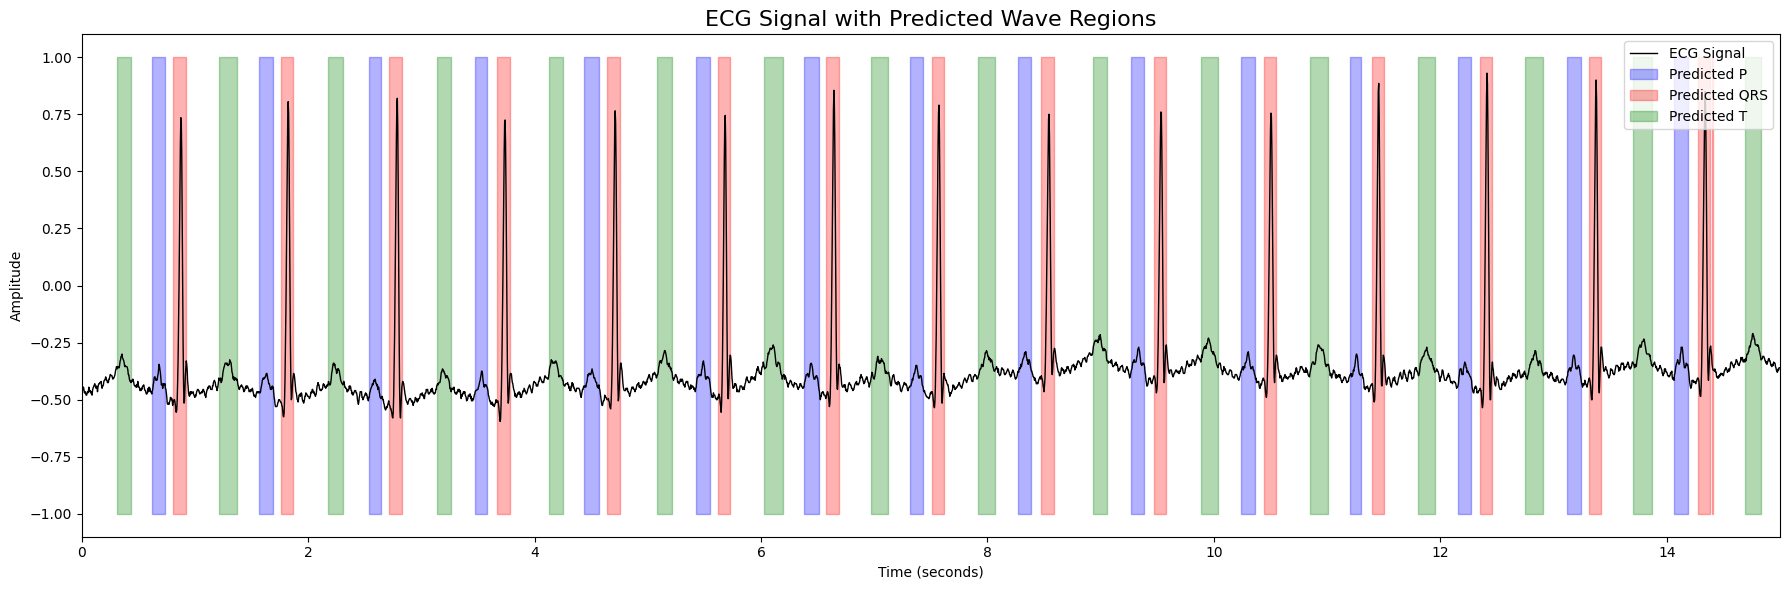

In [ ]:
# Load your test signal (e.g., from wfdb)
#record = wfdb.rdrecord('/content/drive/MyDrive/Final project/dataset/physionet.org/files/ecgiddb/1.0.0/Person_48/rec_1')
record = wfdb.rdrecord(path+'/physionet.org/files/mitdb/1.0.0/205')
signal = record.p_signal[:, 0]  # lead I
fs = record.fs
signal=signal[(10):(25*fs)]

# Predict
pred_labels = predict_full_ecg(signal, model, fs=250)

# Extract wave start/end
boundaries = get_wave_boundaries(pred_labels)
print(boundaries)
visualize_boundaries(signal, boundaries, fs=250, zoom=(0, 15))

{'P': [(123, 150), (401, 430), (680, 709), (960, 987), (1229, 1256), (1495, 1523), (1774, 1802), (2047, 2075), (2311, 2335), (2567, 2596), (2833, 2857), (3096, 3126), (3363, 3394), (3630, 3658), (3889, 3919), (4157, 4183), (4437, 4462), (4703, 4728), (4956, 4984), (5223, 5250), (5487, 5512), (5760, 5790), (6029, 6057), (6296, 6322), (6565, 6590), (6841, 6868), (7105, 7134), (7363, 7391), (7627, 7655), (7894, 7925), (8165, 8198), (8698, 8726)], 'QRS': [(170, 208), (443, 490), (722, 764), (999, 1040), (1271, 1313), (1538, 1580), (1817, 1859), (2091, 2129), (2348, 2387), (2611, 2651), (2877, 2914), (3138, 3181), (3410, 3453), (3674, 3715), (3931, 3973), (4203, 4242), (4479, 4518), (4743, 4784), (5002, 5047), (5270, 5306), (5531, 5573), (5804, 5847), (6071, 6113), (6337, 6377), (6609, 6649), (6884, 6923), (7149, 7188), (7407, 7449), (7676, 7712), (7939, 7981), (8210, 8255), (8408, 8493), (8741, 8781)], 'T': [(0, 19), (264, 310), (536, 586), (809, 867), (1082, 1136), (1353, 1402), (1623, 16

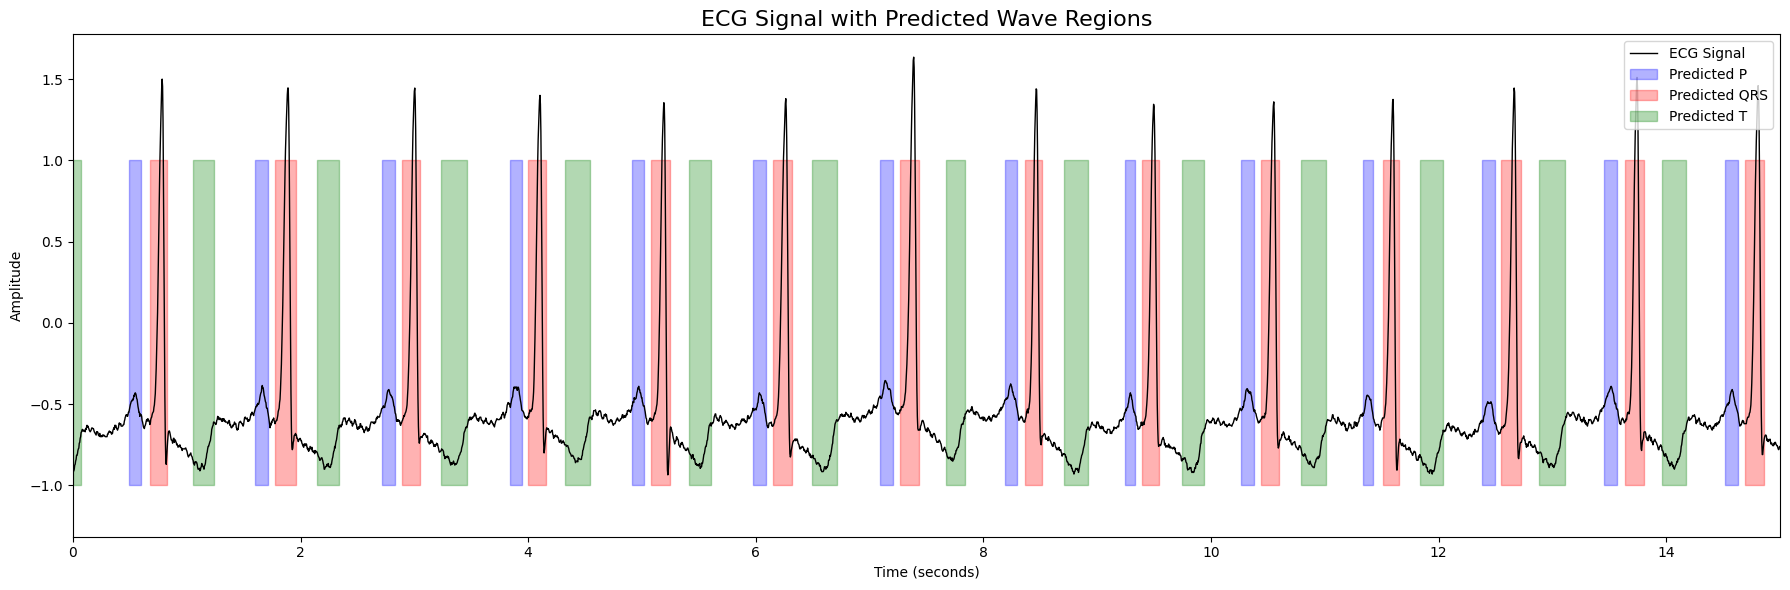

In [ ]:
# Load your test signal (e.g., from wfdb)
#record = wfdb.rdrecord('/content/drive/MyDrive/Final project/dataset/physionet.org/files/ecgiddb/1.0.0/Person_48/rec_1')
record = wfdb.rdrecord(path+'/physionet.org/files/mitdb/1.0.0/223')
signal = record.p_signal[:, 0]  # lead I
fs = record.fs
signal=signal[(10):(25*fs)]

# Predict
pred_labels = predict_full_ecg(signal, model, fs=250)

# Extract wave start/end
boundaries = get_wave_boundaries(pred_labels)
print(boundaries)
visualize_boundaries(signal, boundaries, fs=250, zoom=(0, 15))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')